<center>
<p style="text-align:center"><img alt="Ragas" src="https://github.com/explodinggradients/ragas/blob/main/docs/_static/imgs/logo.png?raw=true" width="400"><br><a href="https://arize.com/docs/phoenix/">Phoenix Docs</a> | <a href="https://github.com/explodinggradients/ragas">Ragas</a> | <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
</p>
    </center>

## 1. Introduction

Building a baseline for a RAG pipeline is not usually difficult, but enhancing it to make it suitable for real-world Arabic question-answering tasks requires careful evaluation, observability, and iterative refinement. Choosing the right tools, retrieval strategies, and LLM configurations can be challenging, especially when working with large and diverse datasets.

This notebook demonstrates how to **evaluate, visualize, and analyze an Arabic RAG pipeline** using a combination of powerful open-source libraries:

- **[Ragas](https://docs.ragas.io/en/stable/)** for evaluation metrics such as faithfulness, answer correctness, context precision, and context recall  
- **Arize AI’s [Phoenix](https://arize.com/docs/phoenix)** for tracing, debugging, embedding visualization, and cluster analysis  
- **[LlamaIndex](https://docs.llamaindex.ai/en/stable/)** for building RAG pipelines, managing document indexes, and connecting retrieval to LLMs  

In this tutorial, instead of using arXiv PDFs, we will work with the **ArabicaQA dataset**, a large-scale Arabic machine-reading comprehension (MRC) dataset containing questions, contexts, and ground-truth answers. This allows us to build and evaluate an **Arabic-focused RAG system** in a realistic setting.

> ℹ️ **Note:**  
> This notebook uses **open-source HuggingFace LLMs** (such as LLaMA or Gemma) and **does not require an OpenAI API key**.


## 2. Install Dependencies and Import Libraries

Install and import Python dependencies.

In [7]:
%pip install -U "ragas[langchain]" pypdf "arize-phoenix[llama-index,embeddings]" "openai>=1.0.0" pandas "httpx<0.28" "openinference-instrumentation>=0.1.38" langchain-core langchain pydantic

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)


In [8]:
!pip install "llama-index>=0.11.0" "llama-index-llms-huggingface"

In [1]:
import torch
print("CUDA:", torch.cuda.is_available())
print("Torch CUDA build:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA: True
Torch CUDA build: 12.6
GPU: NVIDIA A100-SXM4-40GB


In [2]:
import pandas as pd

# Display the complete contents of dataframe cells.
pd.set_option("display.max_colwidth", None)

In [3]:
from huggingface_hub import login
login()  # It will prompt you for your token


In [4]:
from llama_index.core.settings import Settings
from llama_index.llms.huggingface import HuggingFaceLLM

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Reset any previous LLM in LlamaIndex
Settings.llm = None

model_name = "meta-llama/Llama-3.2-1B-Instruct"

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

print("Using device:", device)

# --- Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# --- Model ---
if device == "cuda":
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=dtype,
        device_map="auto",
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=dtype,
    )

print("First model parameter device:", next(model.parameters()).device)

# --- Wrap in LlamaIndex LLM ---
llm = HuggingFaceLLM(
    model=model,
    tokenizer=tokenizer,
    model_name=model_name,
    tokenizer_name=model_name,
    context_window=4096,
    max_new_tokens=256,
    generate_kwargs={
        "do_sample": False,   # greedy, deterministic (good for evaluation)
    },
)

from ragas.llms import LlamaIndexLLMWrapper
evaluator_llm = LlamaIndexLLMWrapper(llm)   # deprecation warning is OK for now

# Register with LlamaIndex (if you use it elsewhere)
Settings.llm = llm


LLM is explicitly disabled. Using MockLLM.
Using device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


First model parameter device: cuda:0


/tmp/ipython-input-480113908.py:52: DeprecationWarning: LlamaIndexLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LlamaIndexLLMWrapper(llm)   # deprecation warning is OK for now


In [5]:
import phoenix as px

(session := px.launch_app()).view()

/usr/lib/python3.12/contextlib.py:144: SAWarning: Skipped unsupported reflection of expression-based index ix_cumulative_llm_token_count_total
  next(self.gen)
/usr/lib/python3.12/contextlib.py:144: SAWarning: Skipped unsupported reflection of expression-based index ix_latency
  next(self.gen)


🌍 To view the Phoenix app in your browser, visit https://x3td0ccbc9n5-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📖 For more information on how to use Phoenix, check out https://arize.com/docs/phoenix
📺 Opening a view to the Phoenix app. The app is running at https://x3td0ccbc9n5-496ff2e9c6d22116-6006-colab.googleusercontent.com/


In [6]:
!pip install openinference-instrumentation-langchain openinference-instrumentation-llama-index

In [7]:
from phoenix.otel import register
from openinference.instrumentation.langchain import LangChainInstrumentor

tracer_provider = register()
LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

print("✅ LangChain tracing enabled!")
print("⚠️  LlamaIndex tracing skipped due to version compatibility")

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: default
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

✅ LangChain tracing enabled!
⚠️  LlamaIndex tracing skipped due to version compatibility


## 4. Load our dataset (ArabicaQA)

In [8]:
from datasets import load_dataset

# Load the MRC split of ArabicaQA from Hugging Face
arabica_mrc = load_dataset(
    "abdoelsayed/ArabicaQA",
    data_files={
        #"train": "MRC/train.json",
        #"validation": "MRC/val.json",
        "test": "MRC/test.json",
    },
    field="data",  # the JSON has a top-level field called "data"
)

arabica_mrc


README.md: 0.00B [00:00, ?B/s]

MRC/test.json:   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['paragraphs'],
        num_rows: 2108
    })
})

In ArabicaQA (MRC task):
The MRC test set contains:
- question
-  context (the correct paragraph from Wikipedia)
-  answers (ground truth answer spans)

We will use:
- context → to build your vector index (RAG knowledge base)
- question → to query your RAG
- answers → ground truth for RAGAS evaluation

In [9]:
test_ds = arabica_mrc["test"]
test_ds[0]


{'paragraphs': [{'context': 'المرصد الحضري لمدينة الرياض ويعرف اختصارًا بمرصد الرياض هو مركز متخصص في وضع نظم مراقبة حضرية لرصد سير عمليات التنمية الحضرية للمدينة، ويهدف إلى فهم الوضع الحالي للمدينة ووضع تصور للاتجاهات المستقبلية، ومراقبة الإنجاز لتحقيق الأهداف واتخاذ القرارات. التأسيس. بدأت أول خطوات إنشاء المرصد في عام 2009م، من الهيئة العليا لتطوير مدينة الرياض؛ ومن ثم أُقرَّ الهيكل التنظيمي للمرصد الحضري الذي يتكون من مجلس ولجنة تنفيذية ومركز. ويترأس مجلس المرصد أمير المنطقة بالإضافة إلى أربعة عشر عضوا، وتتكون اللَّجنة التنفيذية من 15 عضوًا يمثلون أهم مصادر البيانات ذات الصلة بالمؤشرات الحضرية من القطاع الحكومي والقطاع الخاص. المهام. في عام 1434هـ أطلق المرصد الحضري لمدينة الرياض، المؤشرات الحضرية للدورة الأولى التي ضمت (80) مؤشراً، بعد إقرار نتائج تلك المؤشرات في اجتماع الهيئة الثاني لعام 1435هـ، وشملت الحدّ الأدنى من المؤشرات الحضرية العالمية بالإضافة إلى المؤشرات المحلية. يعمل المرصد الحضري لمدينة الرياض على رصد وتقييم اتجاهات التنمية في مدينة الرياض من خلال إنتاج المؤشرات الحضر

## Convert the test set into a clean RAG-ready DataFrame
For RAG, we need:
- knowledge documents → contexts
- evaluation questions → questions
- ground truth → answers

ArabicaQA test samples have 1 context + multiple Q/A pairs, so we must flatten them.

In [10]:
import pandas as pd

def flatten_arabica_mrc(dataset):
    rows = []

    for item in dataset:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answers = qa["answers"]
                # Most have exactly 1 answer
                gt_answer = answers[0]["text"] if len(answers) > 0 else ""

                rows.append({
                    "context": context,
                    "question": question,
                    "ground_truth": gt_answer
                })
    return pd.DataFrame(rows)


df_test = flatten_arabica_mrc(test_ds)
df_test.head()


,context,question,ground_truth
0,المرصد الحضري لمدينة الرياض ويعرف اختصارًا بمرصد الرياض هو مركز متخصص في وضع نظم مراقبة حضرية لرصد سير عمليات التنمية الحضرية للمدينة، ويهدف إلى فهم الوضع الحالي للمدينة ووضع تصور للاتجاهات المستقبلية، ومراقبة الإنجاز لتحقيق الأهداف واتخاذ القرارات. التأسيس. بدأت أول خطوات إنشاء المرصد في عام 2009م، من الهيئة العليا لتطوير مدينة الرياض؛ ومن ثم أُقرَّ الهيكل التنظيمي للمرصد الحضري الذي يتكون من مجلس ولجنة تنفيذية ومركز. ويترأس مجلس المرصد أمير المنطقة بالإضافة إلى أربعة عشر عضوا، وتتكون اللَّجنة التنفيذية من 15 عضوًا يمثلون أهم مصادر البيانات ذات الصلة بالمؤشرات الحضرية من القطاع الحكومي والقطاع الخاص. المهام. في عام 1434هـ أطلق المرصد الحضري لمدينة الرياض، المؤشرات الحضرية للدورة الأولى التي ضمت (80) مؤشراً، بعد إقرار نتائج تلك المؤشرات في اجتماع الهيئة الثاني لعام 1435هـ، وشملت الحدّ الأدنى من المؤشرات الحضرية العالمية بالإضافة إلى المؤشرات المحلية. يعمل المرصد الحضري لمدينة الرياض على رصد وتقييم اتجاهات التنمية في مدينة الرياض من خلال إنتاج المؤشرات الحضرية التي تقدم معلومات موجزة عن الوضع الراهن والاتجاهات المستقبلية المتوقعة وتقيس مستوى الاستجابة للسياسات والبرامج التنفيذية حسب الأهداف لخطط التنمية المستدامة، ويتم ذلك ضمن إطار رصد عالمي يوفر خطة شاملة للرصد والتقييم ويسهل من عملية تحديد المؤشرات الأساسية ضمن مجموعات معيارية تُمكِّن من مقارنة التقدم مع المدن الأخرى ومؤشرات أخرى تعكس خصوصية مدينة الرياض من خلال تحديد الأولويات والقضايا الهامة في المدينة حسب أهداف المخطط الاستراتيجي الشامل لمدينة الرياض، ورؤية المملكة 2030، بالإضافة إلى أولويات الجهات المشاركة بالمرصد التي تشمل القطاع الحكومي والقطاع الخاص والمجتمع المدني. الإنجازات. في مارس 2017 حصل المرصد الحضري بمدينة الرياض على الشهادة الذهبية WCCD ISO 37120 من المجلس العالمي لبيانات المدن في كندا (WCCD).,من الذي يترأس المرصد الحضري لمدينة الرياض؟,يترأس مجلس المرصد أمير المنطقة بالإضافة إلى أربعة عشر عضوا،
1,المرصد الحضري لمدينة الرياض ويعرف اختصارًا بمرصد الرياض هو مركز متخصص في وضع نظم مراقبة حضرية لرصد سير عمليات التنمية الحضرية للمدينة، ويهدف إلى فهم الوضع الحالي للمدينة ووضع تصور للاتجاهات المستقبلية، ومراقبة الإنجاز لتحقيق الأهداف واتخاذ القرارات. التأسيس. بدأت أول خطوات إنشاء المرصد في عام 2009م، من الهيئة العليا لتطوير مدينة الرياض؛ ومن ثم أُقرَّ الهيكل التنظيمي للمرصد الحضري الذي يتكون من مجلس ولجنة تنفيذية ومركز. ويترأس مجلس المرصد أمير المنطقة بالإضافة إلى أربعة عشر عضوا، وتتكون اللَّجنة التنفيذية من 15 عضوًا يمثلون أهم مصادر البيانات ذات الصلة بالمؤشرات الحضرية من القطاع الحكومي والقطاع الخاص. المهام. في عام 1434هـ أطلق المرصد الحضري لمدينة الرياض، المؤشرات الحضرية للدورة الأولى التي ضمت (80) مؤشراً، بعد إقرار نتائج تلك المؤشرات في اجتماع الهيئة الثاني لعام 1435هـ، وشملت الحدّ الأدنى من المؤشرات الحضرية العالمية بالإضافة إلى المؤشرات المحلية. يعمل المرصد الحضري لمدينة الرياض على رصد وتقييم اتجاهات التنمية في مدينة الرياض من خلال إنتاج المؤشرات الحضرية التي تقدم معلومات موجزة عن الوضع الراهن والاتجاهات المستقبلية المتوقعة وتقيس مستوى الاستجابة للسياسات والبرامج التنفيذية حسب الأهداف لخطط التنمية المستدامة، ويتم ذلك ضمن إطار رصد عالمي يوفر خطة شاملة للرصد والتقييم ويسهل من عملية تحديد المؤشرات الأساسية ضمن مجموعات معيارية تُمكِّن من مقارنة التقدم مع المدن الأخرى ومؤشرات أخرى تعكس خصوصية مدينة الرياض من خلال تحديد الأولويات والقضايا الهامة في المدينة حسب أهداف المخطط الاستراتيجي الشامل لمدينة الرياض، ورؤية المملكة 2030، بالإضافة إلى أولويات الجهات المشاركة بالمرصد التي تشمل القطاع الحكومي والقطاع الخاص والمجتمع المدني. الإنجازات. في مارس 2017 حصل المرصد الحضري بمدينة الرياض على الشهادة الذهبية WCCD ISO 37120 من المجلس العالمي لبيانات المدن في كندا (WCCD).,ما هي الإنجازات البارزة التي حققها المرصد الحضري بمدينة الرياض؟,في مارس 2017 حصل المرصد الحضري بمدينة الرياض على الشهادة الذهبية WCCD ISO 37120 من المجلس العالمي لبيانات المدن في كندا (WCCD)
2,المرصد الحضري لمدينة الرياض ويعرف اختصارًا بمرصد الرياض هو مركز متخصص في وضع نظم مراقبة حضرية لرصد سير عمليات التنمية الحضرية للمدينة، ويهدف إلى فهم الوضع الحالي للمدينة ووضع تصور للاتجاهات المستقبلية، ومراقبة الإنجاز لتحقيق الأهداف واتخاذ القرارات. التأسيس. بدأت أول خطوات إنشاء المرصد في ع

In [11]:
df_test.shape

(13970, 3)

In [12]:
import pandas as pd

# Shuffle the dataset safely
df_shuffled = df_test.sample(frac=1, random_state=42)

# Take a representative sample
df_sample = df_shuffled.head(300)

df_sample.shape


(300, 3)

## Deduplicate contexts → build RAG documents

In [13]:
# Make a list of unique contexts (documents)
unique_contexts = df_sample["context"].drop_duplicates().tolist()

len(unique_contexts)


276

In [14]:
print(unique_contexts[0])
print("---------------------------------------")
print(unique_contexts[1])
print("---------------------------------------")
print(unique_contexts[2])


السيخية (بالبنجابيَّة: ਸਿੱਖੀ) هي ديانة توحيدية دارميَّة نشأت في شمالي الهند في نهاية القرن الخامس عشر. وتأتي كلمة «سيخية» من كلمة «سيخ» وهي بدورها تأتي من الجذر السنسكريتي التي تعني التلميذ و في اللغة البالية المريد أو التابع. وهي واحدة من أحدث الأديان الرئيسية في العالم، وهي واحدة من أكبر الديانات في العالم. وتتضمن المعتقدات الأساسية للسيخية، والتي وضِحَت في كتابهم المقدس جورو جرانث صاحب، الإيمان والتأمل في اسم الخالق الواحد، والوحدة الإلهية والمساواة للبشرية جمعاء، والانخراط في خدمة نكران الذات، والسعي لتحقيق العدالة لمصلحة الجميع وازدهارها، وإتباع سلوك معيشة صادق. وفي أوائل القرن الواحد والعشرين كان هناك حوالي 25 مليون سيخي في جميع أنحاء العالم، وتعيش الغالبية العظمى أو 76% (20 مليون) من السيخ في البنجاب، موطن السيخ في شمال غرب الهند، ويعيش حوالي مليوني في الدول الهندية المجاورة، والتي كانت جزءاً من ولاية البنجاب الهندية سابقاً. وسبب انتشارها في العالم هو اعتماد الإنجليز عليهم في بعض الحروب وهجرات السيخ خارج بلادهم، حيث بدأت الهجرة السيخية من الهند البريطانية خلال النصف الثاني من ال

## Build the Vector Index (Embedding + Index + QueryEngine)


In [15]:
import sys
print(sys.executable)

%pip show llama-index


/usr/bin/python3
Name: llama-index
Version: 0.14.9
Summary: Interface between LLMs and your data
Home-page: https://llamaindex.ai
Author: 
Author-email: Jerry Liu <jerry@llamaindex.ai>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: llama-index-cli, llama-index-core, llama-index-embeddings-openai, llama-index-indices-managed-llama-cloud, llama-index-llms-openai, llama-index-readers-file, llama-index-readers-llama-parse, nltk
Required-by: 


In [16]:
!pip install "llama-index-embeddings-huggingface>=0.1.4"

In [17]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import torch
from llama_index.core import Settings

embed_model = HuggingFaceEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

Settings.embed_model = embed_model

test_vec = embed_model.get_text_embedding("hello world")
print("Test embedding length:", len(test_vec))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Test embedding length: 384


## Create LlamaIndex Documents from ArabicaQA contexts

In [18]:
from llama_index.core import Document

documents = [Document(text=c) for c in unique_contexts]
len(documents)


276

## Build the RAG Vector Store using HuggingFace Embeddings

In [19]:
from llama_index.core import Settings, VectorStoreIndex
from llama_index.core import Document

def build_query_engine(documents):

    # reset old config
    Settings.llm = llm
    Settings.embed_model = embed_model
    Settings.callback_manager = None

    # create the index
    vector_index = VectorStoreIndex.from_documents(
        documents,
        embed_model=embed_model
    )

    # query engine
    query_engine = vector_index.as_query_engine(similarity_top_k=2)

    return query_engine

query_engine = build_query_engine(documents)



## Generate model answers for the test questions

In [20]:
model_answers = []

for q in df_sample["question"]:
    try:
        response = query_engine.query(q)
        model_answers.append(response.response)
    except Exception as e:
        print("Error:", e)
        model_answers.append("")

# Add model answers to dataframe
df_sample["model_answer"] = model_answers

df_sample.head()


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for op

context  \
13845  السيخية (بالبنجابيَّة: ਸਿੱਖੀ) هي ديانة توحيدية دارميَّة نشأت في شمالي الهند في نهاية القرن الخامس عشر. وتأتي كلمة «سيخية» من كلمة «سيخ» وهي بدورها تأتي من الجذر السنسكريتي التي تعني التلميذ و في اللغة البالية المريد أو التابع. وهي واحدة من أحدث الأديان الرئيسية في العالم، وهي واحدة من أكبر الديانات في العالم. وتتضمن المعتقدات الأساسية للسيخية، والتي وضِحَت في كتابهم المقدس جورو جرانث صاحب، الإيمان والتأمل في اسم الخالق الواحد، والوحدة الإلهية والمساواة للبشرية جمعاء، والانخراط في خدمة نكران الذات، والسعي لتحقيق العدالة لمصلحة الجميع وازدهارها، وإتباع سلوك معيشة صادق. وفي أوائل القرن الواحد والعشرين كان هناك حوالي 25 مليون سيخي في جميع أنحاء العالم، وتعيش الغالبية العظمى أو 76% (20 مليون) من السيخ في البنجاب، موطن السيخ في شمال غرب الهند، ويعيش حوالي مليوني في الدول الهندية المجاورة، والتي كانت جزءاً من ولاية البنجاب الهندية سابقاً. وسبب انتشارها في العالم هو اعتماد الإنجليز عليهم في بعض الحروب وهجرات السيخ خارج بلادهم، حيث بدأت الهجرة السيخية من الهند البريطانية خلال النصف الثاني من القرن التاسع عشر، عندما أكمل البريطانيون ضمهم للبنجاب.\nتستند السيخية على التعاليم الروحية لمؤسس الديانة وهو الغورو ناناك، وخلفائه التسعة من الغورو البشر. لقب غورو يعني بالهندية المعلم. أما الغورو غورو جوبيند سينغ الملقب بالعاشر، ساهم في الكثير من أجل السيخية، وكان إسهامه في الإضفاء المستمر للطابع الرسمي على الديانة التي أسسها أولًا الغورو السيخ ناناك ديف جي في القرن الخامس عشر إسهامًا جديرًا بالملاحظة. وسمى الكتاب المقدس للسيخ جورو جرانث صاحب كخليفة له، وبالتالي أنهى خط الغورو البشر وجعل ن الكتاب المقدس للسيخ جورو جرانث صاحب الدليل الروحي الديني والدينوي للسيخ. وترفض الديانة السيخية الادعاءات بأن أي تقليد ديني معين له احتكار للحقيقة المطلقة. وتطورت السيخية في أوقات الاضطهاد الديني. حيث تعرض اثنان من أتباع السيخ وهم الغورو أرجان والغورو تيج بهادور للتعذيب وأعدم من قبل حكام المغول بعد رفضهم اعتناق الإسلام. وأثار اضطهاد السيخ تأسيس الخالسا كطلب لحماية حرية الضمير والدين.\nالتاريخ.\nيرتبط تاريخ السيخية ارتباطًا وثيقًا بتاريخ منطقة البنجاب والوضع الاجتماعي السياسي في شمال غرب شبه القارة الهندية في القرن السادس عشر. منذ الحكم المغولي للهند على يد الإمبراطور جهانكير (1605-1707)، كانت السيخية في صراع مع قوانين إمبراطورية المغول، لأنها كانت تؤثر في التعاقب السياسي للمغول في حين تعتز بالأولياء من الإسلام. قُتل العديد من السيخ البارزين على يد حكام المغول لرفضهم الانصياع لأوامرهم، ومعارضتهم لاضطهاد السيخ. من مجموع 10 من الغورو السيخ، عُذب وأُعدم اثنان من المعلمين أنفسهم (الغورو أرجان والغورو تيج بهادور)، وأقرباء مقربين للعديد من الغورو السيخ قُتلو بوحشية دون رحمة (مثل أبناء الغورو جوبيند سينغ البالغين من العمر 6 و9 سنوات)، إلى جانب العديد من الشخصيات الرئيسية الأخرى السيخية التي عُذبت وقُتلت (مثل باندا بهادور، بهاي ماتي داس، بهاي ساتي داس وباهاي ديالا)، على يد الحكام المغول المتجبرين لرفضهم الخضوع لأوامرهم، ومعارضتهم لاضطهاد السيخ والهندوس. بعد ذلك، عسكرت السيخية لمعارضة هيمنة المغول على أرضهم.\nتميّز ظهور الكونفدرالية السيخية تحت حكم الأمراء والسيخ تحت حكم المهراجا رانجيت سينغ بالتسامح الديني والتعايش السلمي والتعددية مع المسيحيين والمسلمين والهندوس في مواقع السلطة. يعد تأسيس إمبراطورية السيخ عادةً ذروة السيخية على المستوى السياسي، خلال هذه الفترة جاءت إمبراطورية السيخ لتشمل كشمير (أقصى شمال شبه القارة الهندية)، ولداخ (إقليم اتحادي تديره الهند)، وبيشاور (هي عاصمة مقاطعة خيبر بختونخوا الباكستانية وأكبر مدنها). اعتنق عدد من الفلاحين المسلمين والهندوس السيخية. أخذ هاري سينغ نالوا، القائد العام لجيش السيخ على طول الحدود الشمالية الغربية، حدود إمبراطورية السيخ إلى مصب ممر خيبر (هو ممر جبلي في شمال غرب باكستان، على الحدود مع أفغانستان). دمجت الإدارة العلمانية لإمبراطورية السيخ إصلاحات عسكرية واقتصادية وحكومية مبتكرة.\nشهدت الأشهر التي سبقت تقسيم الهند (تقسيم الهند البريطانية إلى دولتين مستقلتين، الهند وباكستان) سنة 1947، صراعًا حادًا في البنجاب (منطقة جيوسياسية وثقافية وتاريخية في جنوب آسيا، تحديدًا شمال شبه القارة الهندية، وتضم مناطق في شرق باكستان وشمال الهند) بين السيخ والمسلمين، شهد الهجرة الدينية الفعالة للسيخ البنجاب والهندوس من البنجاب الغربية مقابل هجرة دينية مماثلة للمسلمين البنجاب في شرق البنجاب. في الوقت الحاضر، يعيش غالبية السيخ في ول

In [21]:
import pandas as pd

completed_n = len(model_answers)  # should be 328
df_sample = df_sample.reset_index(drop=True)

# Attach the answers ONLY to the first completed_n rows
df_sample.loc[:completed_n-1, "model_answer"] = model_answers

# Keep only rows that actually have a model answer (not NaN / empty)
df_done = df_sample.iloc[:completed_n].copy()
df_done = df_done[df_done["model_answer"] != ""]

print(df_done.shape)
df_done.head()


(300, 4)


context  \
0  السيخية (بالبنجابيَّة: ਸਿੱਖੀ) هي ديانة توحيدية دارميَّة نشأت في شمالي الهند في نهاية القرن الخامس عشر. وتأتي كلمة «سيخية» من كلمة «سيخ» وهي بدورها تأتي من الجذر السنسكريتي التي تعني التلميذ و في اللغة البالية المريد أو التابع. وهي واحدة من أحدث الأديان الرئيسية في العالم، وهي واحدة من أكبر الديانات في العالم. وتتضمن المعتقدات الأساسية للسيخية، والتي وضِحَت في كتابهم المقدس جورو جرانث صاحب، الإيمان والتأمل في اسم الخالق الواحد، والوحدة الإلهية والمساواة للبشرية جمعاء، والانخراط في خدمة نكران الذات، والسعي لتحقيق العدالة لمصلحة الجميع وازدهارها، وإتباع سلوك معيشة صادق. وفي أوائل القرن الواحد والعشرين كان هناك حوالي 25 مليون سيخي في جميع أنحاء العالم، وتعيش الغالبية العظمى أو 76% (20 مليون) من السيخ في البنجاب، موطن السيخ في شمال غرب الهند، ويعيش حوالي مليوني في الدول الهندية المجاورة، والتي كانت جزءاً من ولاية البنجاب الهندية سابقاً. وسبب انتشارها في العالم هو اعتماد الإنجليز عليهم في بعض الحروب وهجرات السيخ خارج بلادهم، حيث بدأت الهجرة السيخية من الهند البريطانية خلال النصف الثاني من القرن التاسع عشر، عندما أكمل البريطانيون ضمهم للبنجاب.\nتستند السيخية على التعاليم الروحية لمؤسس الديانة وهو الغورو ناناك، وخلفائه التسعة من الغورو البشر. لقب غورو يعني بالهندية المعلم. أما الغورو غورو جوبيند سينغ الملقب بالعاشر، ساهم في الكثير من أجل السيخية، وكان إسهامه في الإضفاء المستمر للطابع الرسمي على الديانة التي أسسها أولًا الغورو السيخ ناناك ديف جي في القرن الخامس عشر إسهامًا جديرًا بالملاحظة. وسمى الكتاب المقدس للسيخ جورو جرانث صاحب كخليفة له، وبالتالي أنهى خط الغورو البشر وجعل ن الكتاب المقدس للسيخ جورو جرانث صاحب الدليل الروحي الديني والدينوي للسيخ. وترفض الديانة السيخية الادعاءات بأن أي تقليد ديني معين له احتكار للحقيقة المطلقة. وتطورت السيخية في أوقات الاضطهاد الديني. حيث تعرض اثنان من أتباع السيخ وهم الغورو أرجان والغورو تيج بهادور للتعذيب وأعدم من قبل حكام المغول بعد رفضهم اعتناق الإسلام. وأثار اضطهاد السيخ تأسيس الخالسا كطلب لحماية حرية الضمير والدين.\nالتاريخ.\nيرتبط تاريخ السيخية ارتباطًا وثيقًا بتاريخ منطقة البنجاب والوضع الاجتماعي السياسي في شمال غرب شبه القارة الهندية في القرن السادس عشر. منذ الحكم المغولي للهند على يد الإمبراطور جهانكير (1605-1707)، كانت السيخية في صراع مع قوانين إمبراطورية المغول، لأنها كانت تؤثر في التعاقب السياسي للمغول في حين تعتز بالأولياء من الإسلام. قُتل العديد من السيخ البارزين على يد حكام المغول لرفضهم الانصياع لأوامرهم، ومعارضتهم لاضطهاد السيخ. من مجموع 10 من الغورو السيخ، عُذب وأُعدم اثنان من المعلمين أنفسهم (الغورو أرجان والغورو تيج بهادور)، وأقرباء مقربين للعديد من الغورو السيخ قُتلو بوحشية دون رحمة (مثل أبناء الغورو جوبيند سينغ البالغين من العمر 6 و9 سنوات)، إلى جانب العديد من الشخصيات الرئيسية الأخرى السيخية التي عُذبت وقُتلت (مثل باندا بهادور، بهاي ماتي داس، بهاي ساتي داس وباهاي ديالا)، على يد الحكام المغول المتجبرين لرفضهم الخضوع لأوامرهم، ومعارضتهم لاضطهاد السيخ والهندوس. بعد ذلك، عسكرت السيخية لمعارضة هيمنة المغول على أرضهم.\nتميّز ظهور الكونفدرالية السيخية تحت حكم الأمراء والسيخ تحت حكم المهراجا رانجيت سينغ بالتسامح الديني والتعايش السلمي والتعددية مع المسيحيين والمسلمين والهندوس في مواقع السلطة. يعد تأسيس إمبراطورية السيخ عادةً ذروة السيخية على المستوى السياسي، خلال هذه الفترة جاءت إمبراطورية السيخ لتشمل كشمير (أقصى شمال شبه القارة الهندية)، ولداخ (إقليم اتحادي تديره الهند)، وبيشاور (هي عاصمة مقاطعة خيبر بختونخوا الباكستانية وأكبر مدنها). اعتنق عدد من الفلاحين المسلمين والهندوس السيخية. أخذ هاري سينغ نالوا، القائد العام لجيش السيخ على طول الحدود الشمالية الغربية، حدود إمبراطورية السيخ إلى مصب ممر خيبر (هو ممر جبلي في شمال غرب باكستان، على الحدود مع أفغانستان). دمجت الإدارة العلمانية لإمبراطورية السيخ إصلاحات عسكرية واقتصادية وحكومية مبتكرة.\nشهدت الأشهر التي سبقت تقسيم الهند (تقسيم الهند البريطانية إلى دولتين مستقلتين، الهند وباكستان) سنة 1947، صراعًا حادًا في البنجاب (منطقة جيوسياسية وثقافية وتاريخية في جنوب آسيا، تحديدًا شمال شبه القارة الهندية، وتضم مناطق في شرق باكستان وشمال الهند) بين السيخ والمسلمين، شهد الهجرة الدينية الفعالة للسيخ البنجاب والهندوس من البنجاب الغربية مقابل هجرة دينية مماثلة للمسلمين البنجاب في شرق البنجاب. في الوقت الحاضر، يعيش غالبية السيخ في ولاية 

In [22]:
df_done.to_csv("df_sample_with_answers_328.csv", index=False)


In [23]:
print(session.url)


https://x3td0ccbc9n6-496ff2e9c6d22116-6006-colab.googleusercontent.com/


## RAGAS Evaluation

In [24]:
!pip install -U "ragas[langchain]" langchain-core langchain pydantic


In [25]:
from ragas.llms import LlamaIndexLLMWrapper

# you already defined `llm = HuggingFaceLLM(...)` and `Settings.llm = llm`

evaluator_llm = LlamaIndexLLMWrapper(llm)


/tmp/ipython-input-843810481.py:5: DeprecationWarning: LlamaIndexLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LlamaIndexLLMWrapper(llm)


In [26]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(
    "sentence-transformers/LaBSE",
    device="cuda" if torch.cuda.is_available() else "cpu"
)


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [27]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/LaBSE",
    model_kwargs={"device": "cuda"},
)


/tmp/ipython-input-3569151.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


In [28]:
# Starting from df_sample with: context, question, ground_truth, model_answer
df_ragas = df_done.copy()

# Rename columns to match Ragas expectations
df_ragas["retrieved_contexts"] = df_ragas["context"].apply(lambda x: [x])  # must be list of strings
df_ragas["response"] = df_ragas["model_answer"]
df_ragas["user_input"] = df_ragas["question"]
df_ragas["reference"] = df_ragas["ground_truth"]  # rename ground_truth to reference

print(df_ragas.columns)
# Should include: 'user_input', 'response', 'retrieved_contexts', 'reference'


Index(['context', 'question', 'ground_truth', 'model_answer',
       'retrieved_contexts', 'response', 'user_input', 'reference'],
      dtype='object')


In [29]:

from ragas import EvaluationDataset
ragas_dataset = EvaluationDataset.from_pandas(df_ragas)


In [30]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness,
)

from ragas import evaluate

result = evaluate(
    ragas_dataset,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_correctness,
    ],
    llm=evaluator_llm,
    embeddings=embeddings,
)
result


Evaluating:   0%|          | 0/1500 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
ERROR:ragas.prompt.pydantic_prompt:Prompt response_relevance_prompt failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.executor:Exception raised in Job[696]: RagasOutputParserException(The output parser failed to parse the output including retries.)
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
ERROR:ragas.prompt.pydantic_prompt:Prompt fix_output_format fa

{'faithfulness': 0.2083, 'answer_relevancy': 0.5207, 'context_precision': 0.5732, 'context_recall': 0.8268, 'answer_correctness': 0.4131}

### Overall RAGAS Scores

In [31]:
import pandas as pd

overall_df = result.to_pandas()
overall_df.to_csv("ragas_overall_scores.csv", index=False)

print("Saved: ragas_overall_scores.csv")


Saved: ragas_overall_scores.csv


In [3]:
import pandas as pd

overall_df = pd.read_csv("ragas_overall_scores_Llama.csv") # i change the name of the file 
overall_df.head()


,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness
0,\nما هي المناطق التي شملتها إمبراطورية السيخ؟,['السيخية (بالبنجابيَّة: ਸਿੱਖੀ) هي ديانة توحيد...,إمبراطورية السيخ هي إمبراطورية إسبانية، وتمت ...,كشمير (أقصى شمال شبه القارة الهندية)، ولداخ (إ...,NaN,0.621423,NaN,NaN,NaN
1,"متى تم عرض المسلسل ""صيفنا الحبيب ؟\n",['صيفنا الحبيب (هانغل: 그 해 우리는)؛ هو مسلسل تلفز...,"تم عرض المسلسل ""صيفنا الحبيب ؟"" في 2023م.",من 6 ديسمبر 2021,0.0,0.693441,NaN,NaN,NaN
2,من هم كبار السن حسب تعريف دولة إسرائيل؟\n\n,"['""العنف ضد كبار السن"" هو مصطلح يشير إلى السلو...",كبار السن حسب تعريف دولة إسرائيل هما الأشخاص ...,الذي يتجاوز عمرهم ال 65 سنة,0.0,NaN,NaN,NaN,NaN
3,ما هي عدم التحمل في نظام الطاقة الكهربائية؟\n,['عدم التحمل في نظام الطاقة الكهربائية هي الحا...,عدم التحمل هو نظام طاقة كهربائية يعتمد على إن...,الحالة التي يكون فيها فقدان التحمل المفاجئ في ...,NaN,0.455248,0.0,NaN,NaN
4,ما هو دور الإلكترونيات في مجال الهندسة الكهربا...,['الهندسة الكهربائية هي تخصص يهتم بدراسة وتطبي...,الإلكترونيات هي أدوات تتبع وتحليل وتحسين وتحس...,.,NaN,0.644414,NaN,NaN,NaN


## Bar Chart + Save

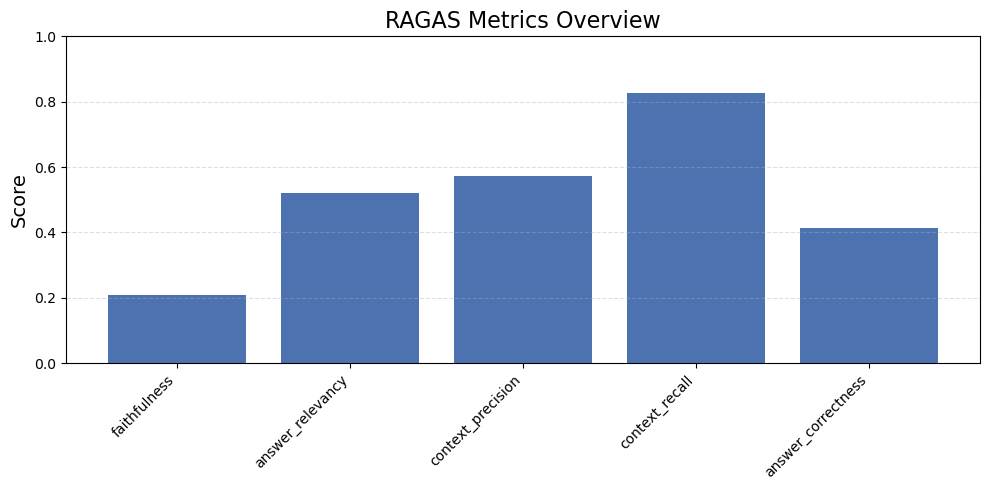

✔ Saved: ragas_bar_chart.png


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("ragas_overall_scores_Llama.csv")

# Select RAGAS metric columns
metrics = ["faithfulness", "answer_relevancy", 
           "context_precision", "context_recall", 
           "answer_correctness"]

# Compute mean score per metric
metric_means = df[metrics].mean().reset_index()
metric_means.columns = ["metric", "value"]

# Plot using your code
plt.figure(figsize=(10, 5))
plt.bar(metric_means["metric"], metric_means["value"], color="#4C72B0")
plt.ylim(0, 1)
plt.title("RAGAS Metrics Overview", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("ragas_bar_chart.png", dpi=400)
plt.show()

print("✔ Saved: ragas_bar_chart.png")


## Line Chart + Save

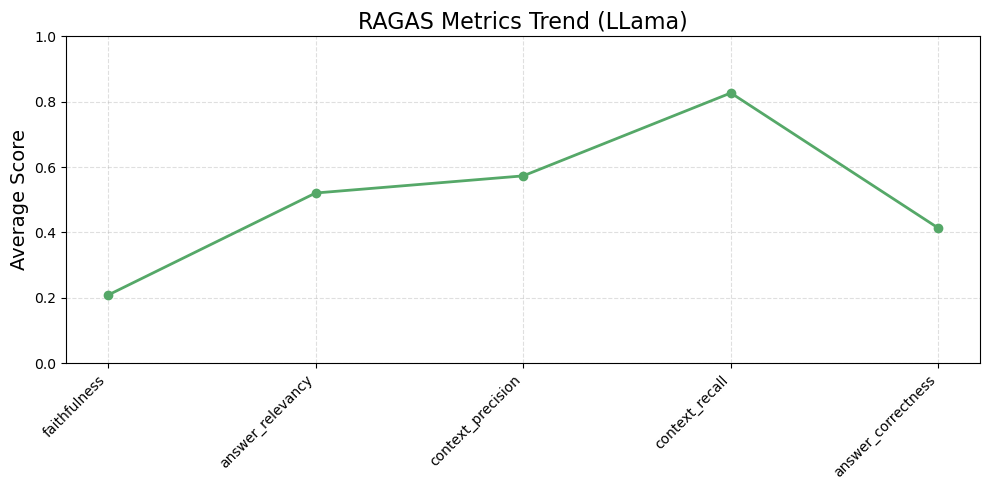

✔ Saved: ragas_line_chart_Llama.png


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your renamed CSV
df = pd.read_csv("ragas_overall_scores_Llama.csv")

# Metrics available in your data
metrics = ["faithfulness", "answer_relevancy", 
           "context_precision", "context_recall", 
           "answer_correctness"]

# Compute average per metric → create a table with metric/value columns
overall_df = df[metrics].mean(skipna=True).reset_index()
overall_df.columns = ["metric", "value"]

# Plot Line Chart
plt.figure(figsize=(10, 5))
plt.plot(overall_df["metric"], overall_df["value"],
         marker="o", linewidth=2, color="#55A868")

plt.ylim(0, 1)
plt.title("RAGAS Metrics Trend (LLama)", fontsize=16)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("ragas_line_chart_Llama.png", dpi=400)
plt.show()

print("✔ Saved: ragas_line_chart_Llama.png")


## Radar Chart (Spider Plot) + Save

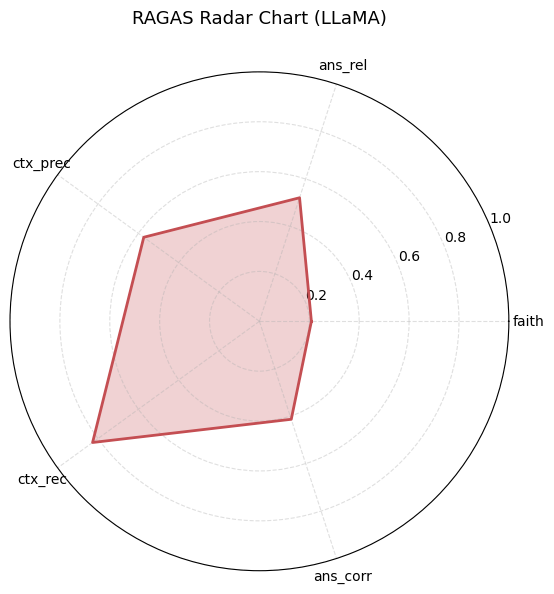

✔ Saved: ragas_radar_chart_pretty.png


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- load + prepare ---
df = pd.read_csv("ragas_overall_scores_Llama.csv")

metrics = ["faithfulness", "answer_relevancy", 
           "context_precision", "context_recall", 
           "answer_correctness"]

overall_df = df[metrics].mean(skipna=True).reset_index()
overall_df.columns = ["metric", "value"]

values = overall_df["value"].tolist()
values = values + values[:1]              # close polygon

angles = np.linspace(0, 2*np.pi, len(values))

# short labels just for plotting
labels_short = ["faith", "ans_rel", "ctx_prec", "ctx_rec", "ans_corr"]

# --- plot radar ---
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values, linewidth=2, color="#C44E52")
ax.fill(angles, values, alpha=0.25, color="#C44E52")

ax.set_thetagrids(angles[:-1] * 180/np.pi, labels_short, fontsize=10)

ax.set_ylim(0, 1)
ax.set_title("RAGAS Radar Chart (LLaMA)", fontsize=13, y=1.08)
ax.grid(True, linestyle="--", alpha=0.4)

plt.subplots_adjust(top=0.85, bottom=0.15)
plt.tight_layout()
plt.savefig("ragas_radar_chart_pretty.png", dpi=400)
plt.show()

print("✔ Saved: ragas_radar_chart_pretty.png")
